<a href="https://colab.research.google.com/github/nahu9815/inteligencia_artificial/blob/main/Chest%20XRay%20VGG16%2020%20epoch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import os
import numpy as np # Linear Algebra
import matplotlib.pyplot as plt # Visualization
import matplotlib.image as implt # Visualization
import seaborn as sns # Visualization


# For Network
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras import Model
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import datetime
from sklearn.metrics import confusion_matrix

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
BATCH_SIZE = 64
EPOCHS = 20

TRAIN_PATH = '/content/drive/MyDrive/INTELIGENCIA_ARTIFICIAL_GRUPO/chest_xray/train/'
TEST_PATH = '/content/drive/MyDrive/INTELIGENCIA_ARTIFICIAL_GRUPO/chest_xray/test/'

TRAIN_NORMAL = os.listdir(TRAIN_PATH + '/NORMAL')
TRAIN_PNEUMONIA = os.listdir(TRAIN_PATH + '/PNEUMONIA')

TEST_NORMAL = os.listdir(TEST_PATH + '/NORMAL')
TEST_PNEUMONIA = os.listdir(TEST_PATH + '/PNEUMONIA')


TARGET_SIZE = (300, 300)
GREY = (3,)
INPUT_SIZE = TARGET_SIZE + GREY

CLASSES = ['Normal','Pneumonia']
if (os.path.exists(TRAIN_PATH) and os.path.exists(TEST_PATH)):
    print('OK')
else:
    print('No existen carpetas')

OK


In [12]:
num_train_normal = len(TRAIN_NORMAL)
num_train_pneumonia = len(TRAIN_PNEUMONIA)
num_train = num_train_normal + num_train_pneumonia 

num_test_normal = len(TEST_NORMAL)
num_test_pneumonia = len(TEST_PNEUMONIA)
num_test = num_test_normal + num_test_pneumonia

num_all = num_train + num_test

print('Normal images in train-set: ', num_train_normal) 
print('Pneumonia images in train-set: ', num_train_pneumonia)
print('Total images in train-set: ', num_train,'--->', round(num_train/num_all,3)*100, 'Percent')

print("\nNormal images in test-set:", num_test_normal)
print("Pneumonia images in test-set:", num_test_pneumonia)
print('Total images in test-set: ', num_test, '--->', round(num_test/num_all,3)*100, 'Percent')

print('\nAll the images in Dataset: ', num_all)

Normal images in train-set:  1349
Pneumonia images in train-set:  3883
Total images in train-set:  5232 ---> 89.3 Percent

Normal images in test-set: 234
Pneumonia images in test-set: 390
Total images in test-set:  624 ---> 10.7 Percent

All the images in Dataset:  5856


In [13]:
train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255,
                                   rotation_range=5, # Randomly rotate my image between 0 and 5 degrees.
                                   width_shift_range=0.1, # Horizontal shift.
                                   height_shift_range=0.1, # Vertical shift.
                                   zoom_range=0.1, # Zoom.
                                   horizontal_flip=True, # Randomly flip inputs horizontally.
                                   samplewise_center=True, # Set each sample mean to 0. 
                                   samplewise_std_normalization=True) # Divide each input by its std.
                                   
train_generator = train_datagen.flow_from_directory(directory=TRAIN_PATH, batch_size=BATCH_SIZE, class_mode='categorical', target_size=TARGET_SIZE, subset='training')

validation_generator = train_datagen.flow_from_directory(directory=TRAIN_PATH, batch_size=BATCH_SIZE, class_mode='categorical', target_size=TARGET_SIZE, subset='validation')

image_train, label_train = train_generator.next()




# Validation\Test should not be augmented.
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(directory=TEST_PATH, batch_size = BATCH_SIZE, class_mode='categorical', target_size=TARGET_SIZE, shuffle=True)

image_test, label_test = test_generator.next()

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

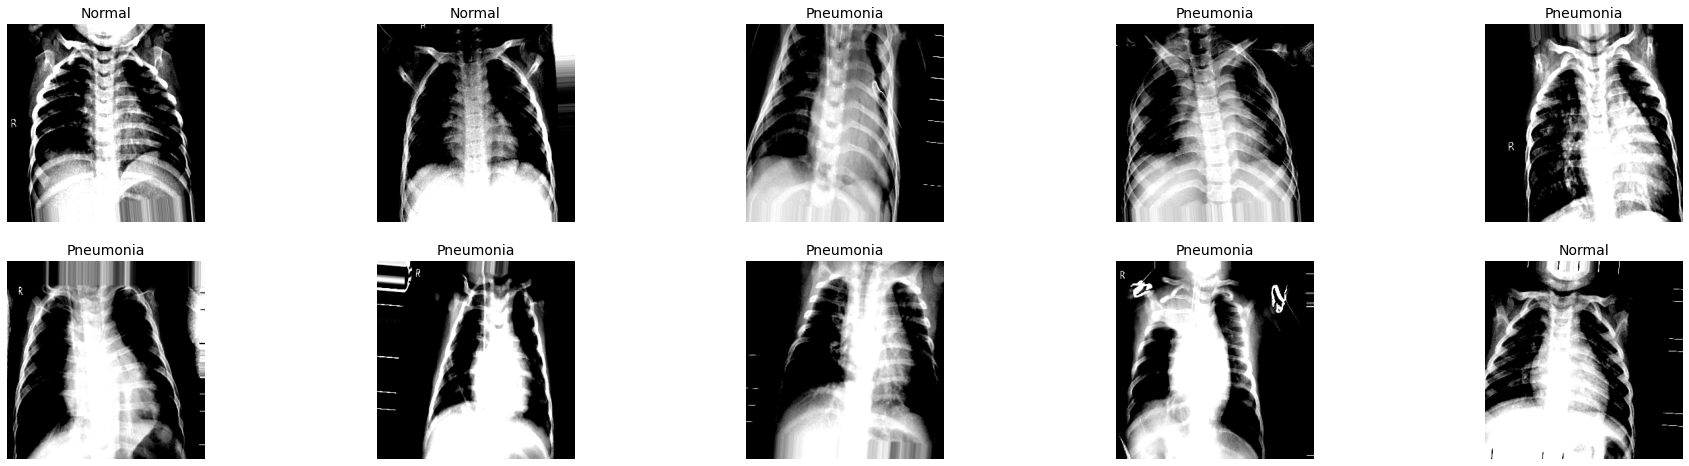

In [14]:
def show_tarin(batch_size, images, labels):
    
    images = images[0:batch_size,:,:,:]
    labels = labels[0:batch_size,:]
    
    image_rows = 2
    image_col = int(batch_size/image_rows)
    
    _, axs = plt.subplots(image_rows, image_col, figsize=(32,8))
    axs = axs.flatten()
    
    for i in range(batch_size):
        img = images[i,:,:,:]
        lab = labels[i,:]
        axs[i].imshow(img)
        axs[i].axis('off')
        lab = np.argmax(lab)
        axs[i].set_title(label = CLASSES[lab], fontsize=14)

    plt.show()
    
    
show_tarin(10, image_train, label_train)

In [15]:
def craete_model():
    
    # Load v3 model without the top layer
    model = VGG16(include_top=False, weights='imagenet',input_shape=INPUT_SIZE)

    # Freeze
    model.trainable = False
    
    # New classifier layers
    flatten = Flatten()(model.layers[-1].output) # Flatt last v3 layer (except the last).
    fc1 = Dense(units=512, activation='relu')(flatten)
    dropout = Dropout(0.05)(fc1)
    output = Dense(2, activation='softmax')(dropout)
   
    # Define a new Model
    model = Model(inputs=model.input, outputs=output)
    
    # Summary
    model.summary()
    
    return model


model = craete_model()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0     

In [16]:
opt = optimizers.Nadam(learning_rate=0.00001)
loss = CategoricalCrossentropy()
met = 'accuracy'

# Compile the Model
model.compile(optimizer=opt, loss=loss, metrics=[met])

In [17]:
# Clear any logs from previous runs
!rm -rf ./logs/ 
!mkdir ./logs/

# From Github Gist: https://gist.github.com/hantoine/4e7c5bc6748861968e61e60bab89e9b0
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile
from subprocess import Popen
from os import chmod
from os.path import isfile
import json
import time
import psutil

def launch_tensorboard():
    tb_process, ngrok_process = None, None
    
    # Launch TensorBoard
    if not is_process_running('tensorboard'):
        tb_command = 'tensorboard --logdir ./logs/ --host 0.0.0.0 --port 6006'
        tb_process = run_cmd_async_unsafe(tb_command)
    
    # Install ngrok
    if not isfile('./ngrok'):
        ngrok_url = 'https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip'
        download_and_unzip(ngrok_url)
        chmod('./ngrok', 0o755)

    # Create ngrok tunnel and print its public URL
    if not is_process_running('ngrok'):
        ngrok_process = run_cmd_async_unsafe('./ngrok http 6006')
        time.sleep(1) # Waiting for ngrok to start the tunnel
    ngrok_api_res = urlopen('http://127.0.0.1:4040/api/tunnels', timeout=10)
    ngrok_api_res = json.load(ngrok_api_res)
    assert len(ngrok_api_res['tunnels']) > 0, 'ngrok tunnel not found'
    tb_public_url = ngrok_api_res['tunnels'][0]['public_url']
    print(f'TensorBoard URL: {tb_public_url}')

    return tb_process, ngrok_process


def download_and_unzip(url, extract_to='.'):
    http_response = urlopen(url)
    zipfile = ZipFile(BytesIO(http_response.read()))
    zipfile.extractall(path=extract_to)


def run_cmd_async_unsafe(cmd):
    return Popen(cmd, shell=True)


def is_process_running(process_name):
    running_process_names = (proc.name() for proc in psutil.process_iter())
    return process_name in running_process_names


tb_process, ngrok_process = launch_tensorboard()

TensorBoard URL: https://a3bdff6da62b.ngrok.io


In [18]:
# For TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%d%m%Y-%H%M%S")

my_callbacks = [EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=5, mode='auto',restore_best_weights=False, verbose=1),

                ModelCheckpoint(filepath='my_model.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch', verbose=1),

                TensorBoard(log_dir=log_dir, histogram_freq=1) ]

In [19]:
history = model.fit(train_generator, # If x is a dataset -> y should not be specified (since targets will be obtained from x).
                    epochs=EPOCHS, batch_size=BATCH_SIZE,
                    validation_data=validation_generator,
                    callbacks=[my_callbacks],
                    verbose=1)

print('\n*** Fit is over ***')
model.save('my_modelInception.h5')

Epoch 1/20
66/66 [==============================] - 1564s 23s/step - loss: 0.2754 - accuracy: 0.8811 - val_loss: 0.1446 - val_accuracy: 0.9512

Epoch 00001: val_accuracy improved from -inf to 0.95120, saving model to my_model.h5
Epoch 2/20
66/66 [==============================] - 154s 2s/step - loss: 0.1324 - accuracy: 0.9561 - val_loss: 0.1131 - val_accuracy: 0.9617

Epoch 00002: val_accuracy improved from 0.95120 to 0.96172, saving model to my_model.h5
Epoch 3/20
66/66 [==============================] - 154s 2s/step - loss: 0.1059 - accuracy: 0.9637 - val_loss: 0.0860 - val_accuracy: 0.9675

Epoch 00003: val_accuracy improved from 0.96172 to 0.96746, saving model to my_model.h5
Epoch 4/20
66/66 [==============================] - 154s 2s/step - loss: 0.0931 - accuracy: 0.9661 - val_loss: 0.0784 - val_accuracy: 0.9761

Epoch 00004: val_accuracy improved from 0.96746 to 0.97608, saving model to my_model.h5
Epoch 5/20
66/66 [==============================] - 154s 2s/step - loss: 0.0831 -

In [20]:
from keras.models import load_model

model = load_model('my_modelInception.h5')

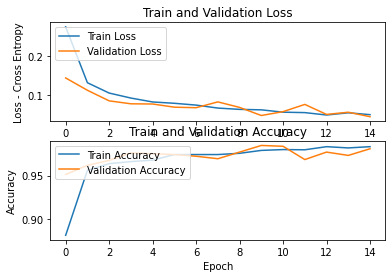

In [21]:
def graphs_learning_display(history):
    
    # Train and Test Loss
    plt.subplot(2,1,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper left')
    plt.xlabel('Epoch')
    plt.ylabel('Loss - Cross Entropy')
    plt.title('Train and Validation Loss')
    
    # Train and Test Accuracy
    plt.subplot(2,1,2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='upper left')
    plt.xlabel('Epoch'),
    plt.ylabel('Accuracy')
    plt.title('Train and Validation Accuracy')
    
    plt.show()
    

graphs_learning_display(history)

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
test_loss = round(test_loss, 6)
test_accuracy = round(test_accuracy*100, 3)

print('Test Loss: ', test_loss)
print('Test Accuracy:', '\033[0m', test_accuracy, '%\033[0m')

In [ ]:
def show(model, batch_size, images, labels):
    
    images = images[0:batch_size,:,:,:]
    labels = labels[0:batch_size,:]
    predict = np.round(model.predict(images))
    
    image_rows = 2
    image_col = int(batch_size/image_rows)
    
    _, axs = plt.subplots(image_rows, image_col, figsize=(32,8))
    axs = axs.flatten()
    
    for i in range(batch_size):
        img = images[i,:,:,:]
        lab = labels[i,:]
        axs[i].imshow(img)
        pred = predict[i]
        axs[i].axis('off')
        lab, pred = np.argmax(lab), np.argmax(pred)
        axs[i].set_title(label = f'True Label: {CLASSES[lab]}  |  Predicted: {CLASSES[pred]}', fontsize=14)

    plt.show()
    
    
show(model, 10, image_test, label_test)

In [ ]:
y_pred = model.predict(test_generator).argmax(axis=-1)

conf_mat = confusion_matrix(test_generator.classes, y_pred)


group_names = ['TN','FP','FN','TP']
group_counts = ['{0:0.0f}'.format(value) for value in conf_mat.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in conf_mat.flatten()/np.sum(conf_mat)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, xticklabels=CLASSES, yticklabels=CLASSES, ax=ax, annot=labels, fmt='', cbar=True, annot_kws={'size': 20}, cmap='Blues')
ax.set_xlabel('Predicted Labels', fontsize=20)
ax.set_ylabel('True Labels', fontsize=20)
plt.title('Confusion Matrix', fontsize=25)

In [ ]:
train_acc = round(np.max(history.history['accuracy'])*100, 2)
valid_acc = round(np.max(history.history['val_accuracy'])*100,2)

print('Training Accuracy:','\033[0m', train_acc, '%\033[0m')
print('Validation Accuracy:','\033[0m', valid_acc, '%\033[0m')
print('Test Accuracy:', '\033[0m', test_accuracy,'%\033[0m')

In [ ]:
from keras.models import load_model

model.save('my_modelInception.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('my_modelInception.h5')

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
from keras.preprocessing import image